In [1]:
import sys, platform
print(sys.executable)
print(platform.python_version())

/usr/bin/python3
3.12.3


In [2]:
from pathlib import Path
root = Path('.')
data_dir = root / 'Data'
data_original_dir = root / 'Data_original'
print('Data dir exists:', data_dir.exists())
print('Data_original dir exists:', data_original_dir.exists())
if data_dir.exists():
    train_dir = data_dir / 'Train'
    val_dir = data_dir / 'Validation'
    print('Train classes:', sorted([p.name for p in train_dir.iterdir() if p.is_dir()]))
    print('Validation classes:', sorted([p.name for p in val_dir.iterdir() if p.is_dir()]))
if data_original_dir.exists():
    train_dir_o = data_original_dir / 'Train'
    val_dir_o = data_original_dir / 'Validation'
    print('Orig Train classes:', sorted([p.name for p in train_dir_o.iterdir() if p.is_dir()]))
    print('Orig Validation classes:', sorted([p.name for p in val_dir_o.iterdir() if p.is_dir()]))

Data dir exists: True
Data_original dir exists: True
Train classes: ['biryani', 'chapli_kebab', 'chocolate_cake', 'samosa', 'seekh_kebab']
Validation classes: ['biryani', 'chapli_kebab', 'chocolate_cake', 'samosa', 'seekh_kebab']
Orig Train classes: ['biryani', 'chapli_kebab', 'chocolate_cake', 'samosa', 'seekh_kebab']
Orig Validation classes: ['biryani', 'chapli_kebab', 'chocolate_cake', 'samosa', 'seekh_kebab']


In [3]:
from pathlib import Path
from collections import Counter

def count_images(root: Path):
    counts = {}
    if not root.exists():
        return counts
    for cls in sorted([p for p in root.iterdir() if p.is_dir()]):
        counts[cls.name] = len(list(cls.glob('*.jpg')))
    return counts

train_counts = count_images(Path('Data')/'Train')
val_counts = count_images(Path('Data')/'Validation')
orig_train_counts = count_images(Path('Data_original')/'Train')
orig_val_counts = count_images(Path('Data_original')/'Validation')

print('Augmented train counts:', train_counts)
print('Augmented val counts:', val_counts)
print('Original train counts:', orig_train_counts)
print('Original val counts:', orig_val_counts)
print('Total augmented train:', sum(train_counts.values()))
print('Total original train:', sum(orig_train_counts.values()))

Augmented train counts: {'biryani': 95, 'chapli_kebab': 95, 'chocolate_cake': 150, 'samosa': 110, 'seekh_kebab': 95}
Augmented val counts: {'biryani': 5, 'chapli_kebab': 4, 'chocolate_cake': 7, 'samosa': 5, 'seekh_kebab': 4}
Original train counts: {'biryani': 19, 'chapli_kebab': 19, 'chocolate_cake': 30, 'samosa': 22, 'seekh_kebab': 19}
Original val counts: {'biryani': 5, 'chapli_kebab': 4, 'chocolate_cake': 7, 'samosa': 5, 'seekh_kebab': 4}
Total augmented train: 545
Total original train: 109


In [4]:
import random, shutil
from pathlib import Path
from collections import defaultdict

seed = 42
random.seed(seed)

source_dirs = [Path('Data_original/Train'), Path('Data_original/Validation')]
out_root = Path('Data_split')

# discover classes from source
classes = [p.name for p in sorted(source_dirs[0].iterdir()) if p.is_dir()]

# collect images per class across train/val
per_class = {}
for cls in classes:
    imgs = []
    for src in source_dirs:
        cls_path = src / cls
        imgs.extend(sorted(cls_path.glob('*.jpg')))
    per_class[cls] = imgs

train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2

# reset output split dirs
if out_root.exists():
    shutil.rmtree(out_root)
for split in ['train', 'val', 'test']:
    for cls in classes:
        (out_root / split / cls).mkdir(parents=True, exist_ok=True)

split_counts = defaultdict(lambda: defaultdict(int))

for cls, imgs in per_class.items():
    imgs = list(imgs)
    random.shuffle(imgs)
    n = len(imgs)
    test_n = max(1, int(round(n * test_ratio)))
    val_n = max(1, int(round(n * val_ratio)))
    if test_n + val_n >= n:
        test_n = max(1, int(n * 0.2))
        val_n = max(1, int(n * 0.2))
        if test_n + val_n >= n:
            val_n = max(1, n - test_n - 1)
    test_imgs = imgs[:test_n]
    val_imgs = imgs[test_n : test_n + val_n]
    train_imgs = imgs[test_n + val_n :]
    for img in train_imgs:
        shutil.copy2(img, out_root / 'train' / cls / img.name)
        split_counts['train'][cls] += 1
    for img in val_imgs:
        shutil.copy2(img, out_root / 'val' / cls / img.name)
        split_counts['val'][cls] += 1
    for img in test_imgs:
        shutil.copy2(img, out_root / 'test' / cls / img.name)
        split_counts['test'][cls] += 1

print('Split counts per class:')
for split in ['train', 'val', 'test']:
    print(split, {cls: split_counts[split][cls] for cls in classes})
print('Totals:', {split: sum(split_counts[split].values()) for split in split_counts})

Split counts per class:
train {'biryani': 14, 'chapli_kebab': 13, 'chocolate_cake': 23, 'samosa': 17, 'seekh_kebab': 13}
val {'biryani': 5, 'chapli_kebab': 5, 'chocolate_cake': 7, 'samosa': 5, 'seekh_kebab': 5}
test {'biryani': 5, 'chapli_kebab': 5, 'chocolate_cake': 7, 'samosa': 5, 'seekh_kebab': 5}
Totals: {'train': 80, 'val': 27, 'test': 27}


In [10]:
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

train_dir = Path('Data_split/train')
val_dir = Path('Data_split/val')
test_dir = Path('Data_split/test')

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    horizontal_flip=True,
    zoom_range=0.2,
    width_shift_range=0.15,
    height_shift_range=0.15,
    brightness_range=[0.8, 1.2],
    shear_range=0.1,
    fill_mode='nearest',
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)
val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False,
)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False,
)

print('Train samples:', train_gen.samples)
print('Val samples:', val_gen.samples, 'shuffle:', val_gen.shuffle)
print('Test samples:', test_gen.samples, 'shuffle:', test_gen.shuffle)
print('Classes:', train_gen.class_indices)

Found 80 images belonging to 5 classes.
Found 27 images belonging to 5 classes.
Found 27 images belonging to 5 classes.
Train samples: 80
Val samples: 27 shuffle: False
Test samples: 27 shuffle: False
Classes: {'biryani': 0, 'chapli_kebab': 1, 'chocolate_cake': 2, 'samosa': 3, 'seekh_kebab': 4}


In [11]:
import os, random, numpy as np, tensorflow as tf

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

IMG_SIZE = (224, 224, 3)
NUM_CLASSES = train_gen.num_classes
print('Num classes:', NUM_CLASSES)

Num classes: 5


In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE)
base_model.trainable = False  # frozen backbone

x = GlobalAveragePooling2D()(base_model.output)
out = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=out)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_gen,
    epochs=5,
    validation_data=val_gen,
    verbose=1,
)
print('Train done.')

j:\Work\Career\Vacations-2025\Food Classifier\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.2375 - loss: 1.8079 - val_accuracy: 0.4444 - val_loss: 1.3863
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 704ms/step - accuracy: 0.5250 - loss: 1.2341 - val_accuracy: 0.6296 - val_loss: 1.0300
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 904ms/step - accuracy: 0.7000 - loss: 0.8863 - val_accuracy: 0.8148 - val_loss: 0.7627
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 716ms/step - accuracy: 0.8000 - loss: 0.7088 - val_accuracy: 0.8889 - val_loss: 0.5535
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 882ms/step - accuracy: 0.9375 - loss: 0.4300 - val_accuracy: 0.9630 - val_loss: 0.4168
Train done.


Test accuracy: 0.9630

Classification report (test):
                precision    recall  f1-score   support

       biryani       1.00      1.00      1.00         5
  chapli_kebab       1.00      1.00      1.00         5
chocolate_cake       1.00      1.00      1.00         7
        samosa       0.83      1.00      0.91         5
   seekh_kebab       1.00      0.80      0.89         5

      accuracy                           0.96        27
     macro avg       0.97      0.96      0.96        27
  weighted avg       0.97      0.96      0.96        27



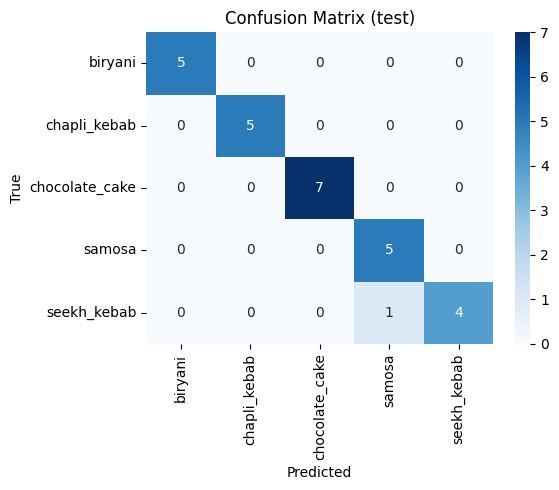

In [14]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import math

test_gen.reset()
steps = math.ceil(test_gen.samples / test_gen.batch_size)
y_probs = model.predict(test_gen, steps=steps, verbose=0)
y_pred = np.argmax(y_probs, axis=1)
y_true = test_gen.classes[: len(y_pred)]
class_names = list(test_gen.class_indices.keys())

test_acc = accuracy_score(y_true, y_pred)
print(f"Test accuracy: {test_acc:.4f}")
print("\nClassification report (test):")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (test)')
plt.tight_layout()
plt.show()

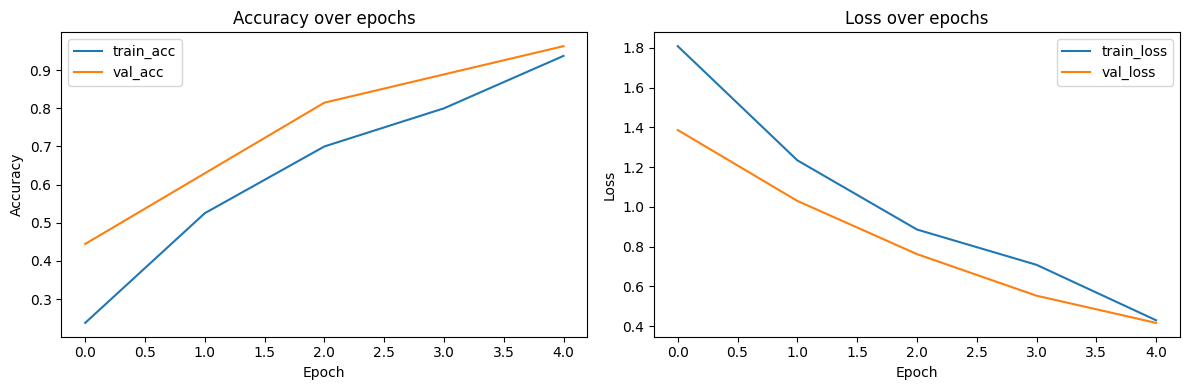

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings('ignore', category=MatplotlibDeprecationWarning)
_gradcam_cache = {}

def make_gradcam_heatmap(img_array, model, last_conv_layer_name='Conv_1'):
    key = last_conv_layer_name
    if key not in _gradcam_cache:
        _gradcam_cache[key] = tf.keras.models.Model(
            [model.inputs],
            [model.get_layer(last_conv_layer_name).output, model.output],
        )
    grad_model = _gradcam_cache[key]

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + tf.keras.backend.epsilon())
    return heatmap.numpy()

def overlay_heatmap(img_path, heatmap, alpha=0.4, cmap='jet'):
    import matplotlib.cm as cm
    img = image.load_img(img_path)
    img = image.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    colormap = cm.get_cmap(cmap)
    colored = colormap(heatmap)
    colored = tf.keras.utils.img_to_array(colored)[:, :, :3]
    colored = tf.image.resize(colored, (img.shape[0], img.shape[1]))

    overlay = colored * alpha + img
    overlay = tf.clip_by_value(overlay, 0, 255).numpy().astype('uint8')
    return img.astype('uint8'), overlay

def preprocess_for_model(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    arr = image.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    return preprocess_input(arr)

print('Grad-CAM helpers ready.')


Grad-CAM helpers ready.


j:\Work\Career\Vacations-2025\Food Classifier\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_322']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


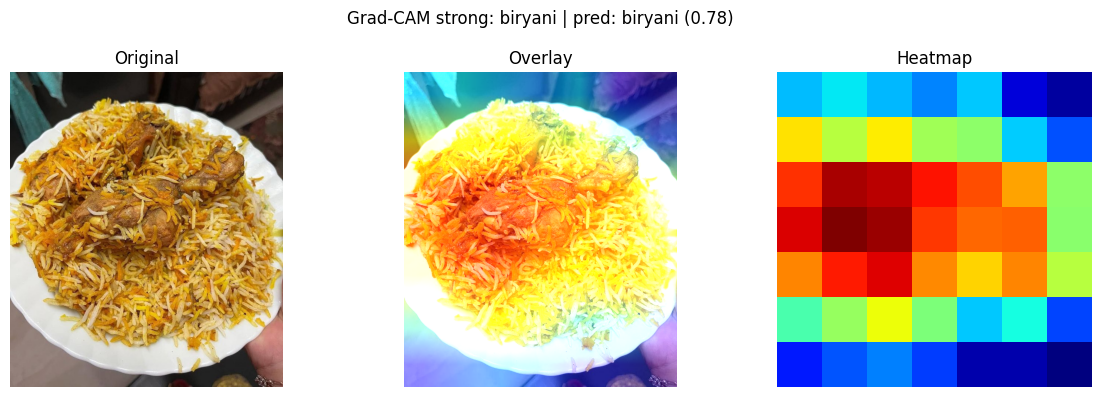

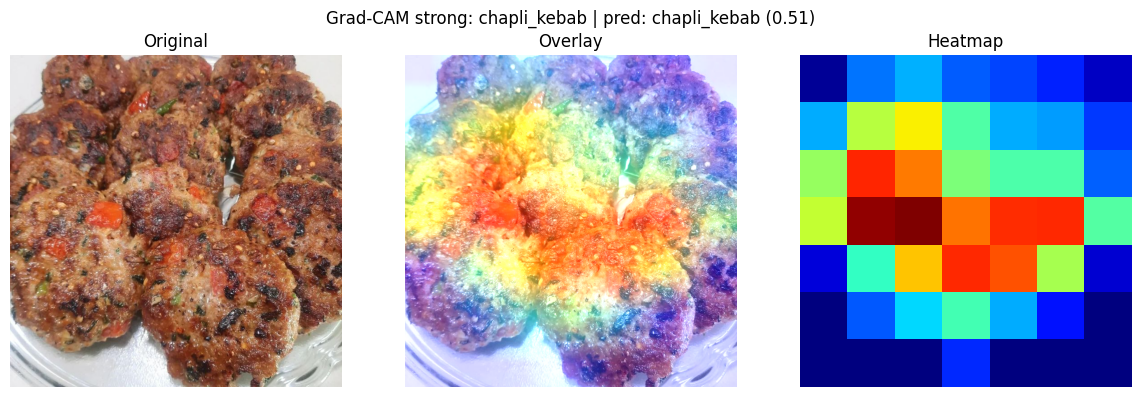

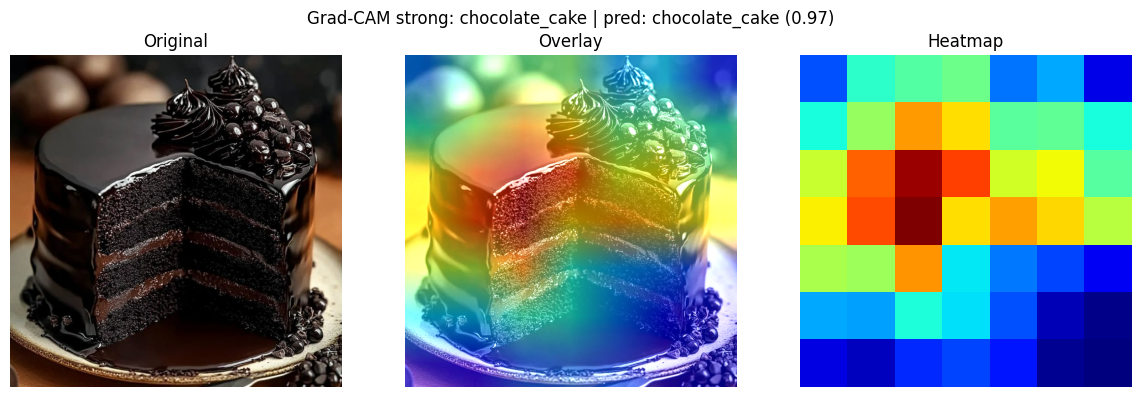

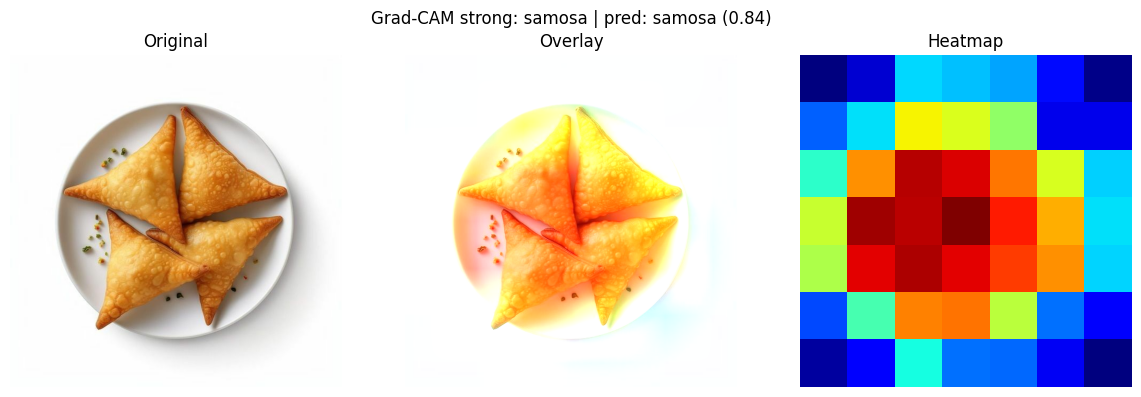

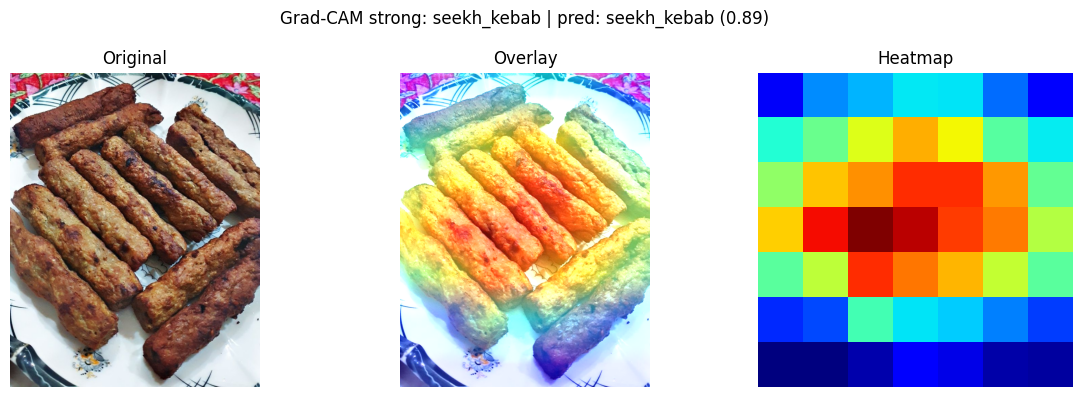

In [22]:
# Stronger Grad-CAM overlay + explicit heatmap
import matplotlib.cm as cm
import numpy as np
from pathlib import Path
import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings('ignore', category=MatplotlibDeprecationWarning)

def overlay_heatmap_strong(img_path, heatmap, alpha=0.65, cmap='jet'):
    img = image.load_img(img_path)
    img = image.img_to_array(img).astype('float32') / 255.0
    heatmap_uint8 = np.uint8(255 * heatmap)
    colormap = cm.get_cmap(cmap)
    colored = colormap(heatmap_uint8)[..., :3]
    colored = tf.image.resize(colored, (img.shape[0], img.shape[1])).numpy()
    overlay = np.clip(colored * alpha + img, 0, 1)
    return (img * 255).astype('uint8'), (overlay * 255).astype('uint8'), heatmap_uint8

sample_paths = []
for cls in ['biryani', 'chapli_kebab', 'chocolate_cake', 'samosa', 'seekh_kebab']:
    candidates = sorted((Path('Data_split/test') / cls).glob('*.jpg'))
    if candidates:
        sample_paths.append(candidates[0])

for img_path in sample_paths:
    arr = preprocess_for_model(img_path)
    heatmap = make_gradcam_heatmap(arr, model, last_conv_layer_name='Conv_1')
    original, overlay, heatmap_uint8 = overlay_heatmap_strong(img_path, heatmap)
    preds = model(arr, training=False).numpy()[0]
    pred_idx = np.argmax(preds)
    class_names = list(train_gen.class_indices.keys())
    pred_label = class_names[pred_idx]
    conf = preds[pred_idx]

    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Grad-CAM strong: {img_path.parent.name} | pred: {pred_label} ({conf:.2f})")
    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.axis('off')
    plt.title('Original')
    plt.subplot(1, 3, 2)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title('Overlay')
    plt.subplot(1, 3, 3)
    plt.imshow(heatmap_uint8, cmap='jet')
    plt.axis('off')
    plt.title('Heatmap')
    plt.tight_layout()
    plt.show()
